# System analysis

### 1) Load data from BIN files

In [61]:
### Load data from disk
import pickle
with open('aida_agdistis.bin', 'rb') as outfile:
    aida_agd_articles=pickle.load(outfile)
with open('wes2015_agdistis.bin', 'rb') as outfile:
    wes_agd_articles=pickle.load(outfile)
with open('aida_spotlight.bin', 'rb') as outfile:
    aida_spot_articles=pickle.load(outfile)
with open('wes2015_spotlight.bin', 'rb') as outfile:
    wes_spot_articles=pickle.load(outfile)
    
wes_title='wes2015'
aida_title='aida'

In [62]:
import utils
import plot_utils
import time
from collections import defaultdict

**1.1. Pick dataset**

In [63]:
print(type(aida_agd_articles))
spot_articles=aida_spot_articles.union(wes_spot_articles)
agd_articles=aida_agd_articles.union(wes_agd_articles)
#print(len(articles))
skip_nils=True

<class 'set'>


### 2) Overall performance

<span style="background-color:lightgreen">Section 6.1. of the paper</span>

In [64]:
print("AGDISTIS")
agd_acc=plot_utils.overall_performance(agd_articles, skip_nils)
print(agd_acc)
print()
print("SPOTLIGHT")
spot_acc=plot_utils.overall_performance(spot_articles, skip_nils)
print(spot_acc)

AGDISTIS
26695 56404
0.4732820367349833

SPOTLIGHT
38180 56404
0.6769023473512517


### 3) Correlation between FORM frequency and accuracy

# Note: All stats from here on are on both datasets jointly, with Spotlight

<span style="background-color:lightgreen">Section 6.2. of the paper</span>

<span style="background-color:yellow">TODO: REFACTOR</span>

**3.1. Correct and total amount per form**

In [65]:
articles=agd_articles

In [66]:
correct_by_form = defaultdict(int)
total_by_form = defaultdict(int)
for article in articles:
    for entity in article.entity_mentions:
        if entity.sys_link and (not skip_nils or entity.gold_link!='--NME--'):
            if entity.sys_link==entity.gold_link:
                correct_by_form[entity.mention]+=1
            total_by_form[entity.mention]+=1

**3.2. Aggregate per frequency**

In [67]:
from collections import OrderedDict
agg_per_frequency=OrderedDict()
forms_by_count=defaultdict(set)
for form, count in total_by_form.items():
    str_count=str(count)
    if count not in agg_per_frequency:
        agg_per_frequency[count]={'c':0, 't':0}
    agg_per_frequency[count]['c']+=correct_by_form[form]
    agg_per_frequency[count]['t']+=count
    forms_by_count[count].add(form)
print(agg_per_frequency)

OrderedDict([(2, {'c': 3240, 't': 5912}), (1, {'c': 6639, 't': 11830}), (17, {'c': 248, 't': 646}), (129, {'c': 87, 't': 129}), (63, {'c': 122, 't': 252}), (3, {'c': 2126, 't': 3957}), (9, {'c': 562, 't': 1548}), (14, {'c': 287, 't': 854}), (12, {'c': 345, 't': 1104}), (49, {'c': 49, 't': 147}), (7, {'c': 790, 't': 1876}), (5, {'c': 1160, 't': 2490}), (8, {'c': 576, 't': 1560}), (4, {'c': 1495, 't': 3044}), (41, {'c': 0, 't': 205}), (116, {'c': 191, 't': 232}), (58, {'c': 8, 't': 116}), (20, {'c': 151, 't': 400}), (210, {'c': 303, 't': 420}), (11, {'c': 379, 't': 1012}), (13, {'c': 269, 't': 988}), (37, {'c': 0, 't': 74}), (32, {'c': 64, 't': 96}), (10, {'c': 592, 't': 1480}), (6, {'c': 1097, 't': 2070}), (30, {'c': 120, 't': 390}), (15, {'c': 211, 't': 720}), (33, {'c': 22, 't': 165}), (23, {'c': 131, 't': 322}), (16, {'c': 180, 't': 688}), (19, {'c': 209, 't': 456}), (464, {'c': 0, 't': 464}), (44, {'c': 84, 't': 176}), (53, {'c': 35, 't': 53}), (61, {'c': 34, 't': 61}), (113, {'c': 

In [68]:
accs=OrderedDict()
for key in sorted(agg_per_frequency, reverse=True):
    acc=agg_per_frequency[key]['c']*100.0/agg_per_frequency[key]['t']
    print(key, acc, forms_by_count[key])
    accs[key]=acc

464 0.0 {'U.S.'}
351 89.74358974358974 {'Germany'}
274 67.51824817518248 {'France'}
237 58.22784810126582 {'England'}
210 72.14285714285714 {'German', 'Australia'}
195 94.35897435897436 {'Italy'}
185 95.67567567567568 {'Spain'}
184 2.717391304347826 {'Britain'}
180 85.0 {'Russia'}
157 73.2484076433121 {'London'}
156 70.51282051282051 {'China'}
147 50.0 {'French', 'LONDON'}
143 8.391608391608392 {'NEW YORK'}
139 66.18705035971223 {'Japan'}
132 95.45454545454545 {'United States'}
129 67.44186046511628 {'Russian'}
116 82.32758620689656 {'mathematics', 'Sweden'}
113 0.0 {'British'}
109 74.31192660550458 {'Reuters', 'Israel'}
103 30.097087378640776 {'Pakistan'}
102 59.80392156862745 {'Paris', 'American'}
101 0.0 {'English'}
98 46.93877551020408 {'Belgium', 'Iraq'}
96 8.333333333333334 {'Europe'}
95 58.94736842105263 {'Berlin'}
93 93.54838709677419 {'Clinton'}
90 37.77777777777778 {'India'}
85 30.58823529411765 {'Netherlands', 'CHICAGO'}
84 77.38095238095238 {'Austria'}
81 87.65432098765432 

**3.3. Plot frequency distribution**

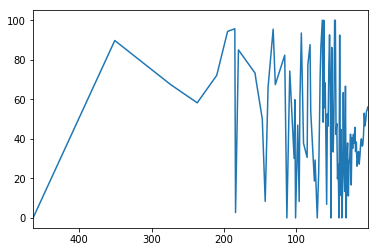

In [69]:
import matplotlib.pyplot as plt
plt.xlim(list(accs.keys())[0],list(accs.keys())[-1])
plt.plot(list(accs.keys()), list(accs.values()))
plt.show()

### 4) Correlation between instance frequency and accuracy

<span style="background-color:lightgreen">Section 6.3. of the paper</span>

<span style="background-color:yellow">TODO: REFACTOR</span>

**4.1. Correct and total amount per URI**

In [70]:
correct_by_uri = defaultdict(int)
total_by_uri = defaultdict(int)
pageranks = defaultdict(set)
uri_pageranks={}
for article in articles:
    for entity in article.entity_mentions:
        if entity.sys_link and (not skip_nils or entity.gold_link!='--NME--'):
            if entity.sys_link==entity.gold_link:
                correct_by_uri[entity.gold_link]+=1
            total_by_uri[entity.gold_link]+=1
            pagerank=int(entity.gold_pr)
            pageranks[pagerank].add(entity.gold_link)
            uri_pageranks[entity.gold_link]=entity.gold_pr

**4.2. Aggregate per frequency**

In [71]:
from collections import OrderedDict
agg_per_frequency=OrderedDict()
uris_by_count=defaultdict(set)
for uri, count in total_by_uri.items():
    str_count=str(count)
    if count not in agg_per_frequency:
        agg_per_frequency[count]={'c':0, 't':0}
    agg_per_frequency[count]['c']+=correct_by_uri[uri]
    agg_per_frequency[count]['t']+=count
    uris_by_count[count].add(uri)
print(agg_per_frequency)

OrderedDict([(23, {'c': 123, 't': 299}), (1, {'c': 4123, 't': 7689}), (17, {'c': 320, 't': 935}), (336, {'c': 245, 't': 336}), (76, {'c': 111, 't': 152}), (3, {'c': 1773, 't': 3462}), (4, {'c': 1411, 't': 3044}), (11, {'c': 636, 't': 1419}), (18, {'c': 258, 't': 756}), (12, {'c': 486, 't': 1308}), (7, {'c': 733, 't': 1820}), (5, {'c': 1182, 't': 2405}), (10, {'c': 727, 't': 1670}), (2, {'c': 2609, 't': 4992}), (9, {'c': 684, 't': 1485}), (8, {'c': 815, 't': 1792}), (103, {'c': 1, 't': 103}), (64, {'c': 205, 't': 320}), (129, {'c': 89, 't': 129}), (69, {'c': 5, 't': 69}), (58, {'c': 36, 't': 116}), (25, {'c': 74, 't': 225}), (563, {'c': 473, 't': 563}), (14, {'c': 344, 't': 840}), (22, {'c': 330, 't': 572}), (13, {'c': 421, 't': 1196}), (33, {'c': 110, 't': 297}), (6, {'c': 1008, 't': 1950}), (16, {'c': 419, 't': 1024}), (26, {'c': 50, 't': 208}), (35, {'c': 73, 't': 280}), (42, {'c': 15, 't': 84}), (44, {'c': 35, 't': 220}), (20, {'c': 228, 't': 380}), (752, {'c': 193, 't': 752}), (60,

In [72]:
accs=OrderedDict()
for key in sorted(agg_per_frequency, reverse=True):
    acc=agg_per_frequency[key]['c']*100.0/agg_per_frequency[key]['t']
    print(key, acc, uris_by_count[key])
    accs[key]=acc

752 25.664893617021278 {'United_States'}
563 84.01420959147424 {'Germany'}
381 49.08136482939633 {'France'}
336 72.91666666666667 {'Russia'}
308 86.03896103896103 {'London'}
287 4.181184668989547 {'United_Kingdom'}
255 72.54901960784314 {'Italy'}
226 64.60176991150442 {'England'}
222 81.53153153153153 {'Spain'}
213 89.67136150234742 {'Australia'}
195 49.23076923076923 {'Israel'}
191 58.1151832460733 {'China'}
185 3.2432432432432434 {'Iraq'}
172 18.6046511627907 {'New_York_City'}
170 33.529411764705884 {'Netherlands'}
166 5.421686746987952 {'Europe'}
163 57.05521472392638 {'Japan'}
156 52.56410256410256 {'Paris'}
139 97.12230215827338 {'Belgium'}
131 90.07633587786259 {'Sweden'}
129 68.9922480620155 {'Mathematics'}
117 94.87179487179488 {'Bill_Clinton'}
116 62.06896551724138 {'Canada'}
112 70.08928571428571 {'Poland', 'Switzerland'}
110 100.0 {'Reuters'}
109 52.293577981651374 {'Berlin'}
104 32.69230769230769 {'India'}
103 0.970873786407767 {'Year'}
97 32.98969072164948 {'Brazil'}
95 68

In [73]:
print(agg_per_frequency)

OrderedDict([(23, {'c': 123, 't': 299}), (1, {'c': 4123, 't': 7689}), (17, {'c': 320, 't': 935}), (336, {'c': 245, 't': 336}), (76, {'c': 111, 't': 152}), (3, {'c': 1773, 't': 3462}), (4, {'c': 1411, 't': 3044}), (11, {'c': 636, 't': 1419}), (18, {'c': 258, 't': 756}), (12, {'c': 486, 't': 1308}), (7, {'c': 733, 't': 1820}), (5, {'c': 1182, 't': 2405}), (10, {'c': 727, 't': 1670}), (2, {'c': 2609, 't': 4992}), (9, {'c': 684, 't': 1485}), (8, {'c': 815, 't': 1792}), (103, {'c': 1, 't': 103}), (64, {'c': 205, 't': 320}), (129, {'c': 89, 't': 129}), (69, {'c': 5, 't': 69}), (58, {'c': 36, 't': 116}), (25, {'c': 74, 't': 225}), (563, {'c': 473, 't': 563}), (14, {'c': 344, 't': 840}), (22, {'c': 330, 't': 572}), (13, {'c': 421, 't': 1196}), (33, {'c': 110, 't': 297}), (6, {'c': 1008, 't': 1950}), (16, {'c': 419, 't': 1024}), (26, {'c': 50, 't': 208}), (35, {'c': 73, 't': 280}), (42, {'c': 15, 't': 84}), (44, {'c': 35, 't': 220}), (20, {'c': 228, 't': 380}), (752, {'c': 193, 't': 752}), (60,

**4.3. Plot accuracies**

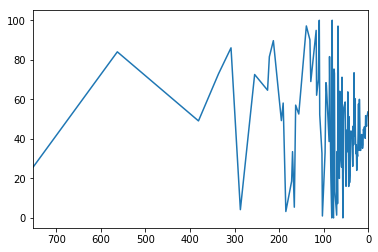

In [74]:
import matplotlib.pyplot as plt
plt.xlim(list(accs.keys())[0],list(accs.keys())[-1])
plt.plot(list(accs.keys()), list(accs.values()))
plt.show()

#### 4.4. Plot PageRank vs accuracy

In [75]:
skip_zeros=True

In [76]:
pg_accs={}
for pr in sorted(pageranks.keys()):
    if skip_zeros and pr==0: continue
    c=0
    t=0
    uris=pageranks[pr]
    for uri_with_pr in uris:
        c+=correct_by_uri[uri_with_pr]
        t+=total_by_uri[uri_with_pr]
    acc=c/t
    pg_accs[pr]=acc

In [77]:
pg_accs

{1: 0.39858039858039856,
 2: 0.4126832377310389,
 3: 0.5040363269424823,
 4: 0.5140997830802603,
 5: 0.5333904109589042,
 6: 0.6144018583042973,
 7: 0.5946524064171123,
 8: 0.5621500559910414,
 9: 0.5424836601307189,
 10: 0.6166666666666667,
 11: 0.5919732441471572,
 12: 0.45454545454545453,
 13: 0.5155709342560554,
 14: 0.46904315196998125,
 15: 0.6242171189979123,
 16: 0.5804597701149425,
 17: 0.3224852071005917,
 18: 0.47880299251870323,
 19: 0.6013289036544851,
 20: 0.5050167224080268,
 21: 0.4602272727272727,
 22: 0.5818181818181818,
 23: 0.41025641025641024,
 24: 0.43869209809264303,
 25: 0.4025423728813559,
 26: 0.43217665615141954,
 27: 0.4035714285714286,
 28: 0.31645569620253167,
 29: 0.581267217630854,
 30: 0.4226415094339623,
 31: 0.4430379746835443,
 32: 0.4375,
 33: 0.4892703862660944,
 34: 0.3524229074889868,
 35: 0.43902439024390244,
 36: 0.37362637362637363,
 37: 0.4411764705882353,
 38: 0.3415841584158416,
 39: 0.23333333333333334,
 40: 0.6103286384976526,
 41: 0.2988

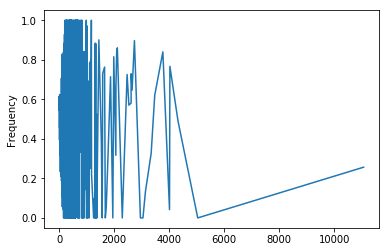

In [78]:
plot_utils.plot_freq_noagg(pg_accs)

### 5) Correlation between instance ranks (of a form) and accuracy

<span style="background-color:lightgreen">Section 6.4. of the paper</span>


**5.1. Collect interpretations for a form**


In [79]:
interpretations=defaultdict(set)
for article in articles:
    for mention in article.entity_mentions:
        form=mention.mention
        meaning=mention.gold_link
        if not skip_nils or meaning!='--NME--':
            interpretations[form].add(meaning)

In [80]:
interpretations['Marseille']

{'Marseille', 'Olympique_de_Marseille'}

**5.2. Aggregate per rank**

In [81]:
ambiguity={}
for form,meanings in interpretations.items():
    ambiguity[form]=len(meanings)
ambiguity

{'Nikolai Ivanovich Lobachevsky': 1,
 'February 24': 1,
 '1856': 1,
 'Russian': 2,
 'mathematician': 1,
 'geometer': 1,
 'hyperbolic geometry': 1,
 "Lobachevsky's": 1,
 'János Bolyai': 1,
 'non-Euclidean geometry': 1,
 'Lobachevskian geometry': 1,
 'Nikolai Lobachevsky': 1,
 'children': 2,
 'Nizhny Novgorod': 1,
 'in Russia': 1,
 '1792': 1,
 'parents': 2,
 'Polish': 2,
 'origin': 2,
 'clerk': 1,
 'land': 1,
 'mother': 1,
 'Kazan': 1,
 'government': 1,
 'scholarships': 1,
 'Lobachevsky': 1,
 'Kazan Gymnasium': 1,
 '1802': 1,
 'graduating': 1,
 '1807': 1,
 'scholarship': 1,
 'Kazan University': 1,
 'years': 1,
 '1804': 1,
 'medicine': 1,
 'course': 1,
 'mathematics': 1,
 'physics': 1,
 'professor': 1,
 'Martin Bartels': 1,
 'school teacher': 1,
 'friend': 2,
 'German': 4,
 'Carl Friedrich Gauss': 1,
 'Bartels': 1,
 'knowledge': 1,
 "Master's degree": 1,
 '1811': 1,
 '1814': 1,
 'lecturer': 1,
 '1816': 1,
 'associate professor': 1,
 '1822': 1,
 'the age': 2,
 'full professor': 1,
 'teachi

In [82]:
correct_per_form=defaultdict(dict)
total_per_form=defaultdict(dict)
for article in articles:
    for mention in article.entity_mentions:
        form=mention.mention
        meaning=mention.gold_link
        if skip_nils and meaning=='--NME--':
            continue
        if ambiguity[form]==1:
            continue
        if meaning not in total_per_form[form]:
            total_per_form[form][meaning]=0
            correct_per_form[form][meaning]=0
        total_per_form[form][meaning]+=1
        if meaning==mention.sys_link:
            correct_per_form[form][meaning]+=1

In [83]:
len(total_per_form)

1046

In [84]:
correct_per_rank, total_per_rank = plot_utils.prepare_ranks(correct_per_form, total_per_form)
print(correct_per_rank)
print(total_per_rank)

Russian
children
parents
Polish
origin
friend
German
the age
rector
health
influence
1850s
theorem
point
on the line
1829
1830
St. Petersburg
result
spirit
of stars
interpretation
surface
Gauss
results
interests
mechanics
significance
proof
1871
U.S.
WASHINGTON
Washington
Scotland
British
Nobel Prize
Paris
France
King's College
photographs
Watson
Nature
1956
French
discovery
Joseph
father
papers
position
Spain
balloon
part
use
substances
composition
compounds
achievement
Law
elements
reaction
Swedish
English
Dalton
compound
theory
Indonesia
American
United States
Philadelphia
Mississippi
South Korea
World Cup
Japan
Russia
China
Germany
Netherlands
Dutch
Wall Street
Romania
Macedonia
European
European Cup
NEW YORK
Belarus
Switzerland
Austria
Czech Republic
Sweden
Bayer Leverkusen
Karlsruhe
Carl
Dundee
Freiburg
Mulder
Spanish
1904
print
Ukraine
Leningrad
1925
quantum theory
Cambridge
help
Academy of Sciences
friends
London
1930s
Navy
structures
stars
Sun
radiation
University of Colorado


defaultdict(<class 'float'>, {1: 0.41244522348816826, 2: 0.18730283911671924, 3: 0.10262008733624454, 4: 0.0423728813559322, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0})


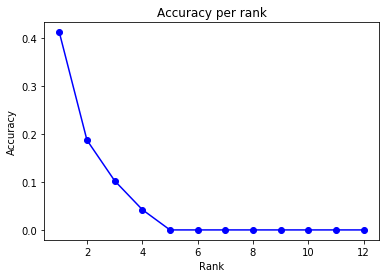

In [85]:
plot_utils.plot_ranks(correct_per_rank, total_per_rank)

### 6) Ranks of the top-N most frequent forms

<span style="background-color:lightgreen">Section 6.5. of the paper</span>


In [86]:
# Top 10 have form frequency of >135

min_frequency=135
correct_per_rank, total_per_rank = plot_utils.prepare_ranks(correct_per_form, total_per_form, min_frequency=min_frequency)
print(correct_per_rank)
print(total_per_rank)

German
U.S.
France
French
Spain
Japan
Russia
China
Germany
NEW YORK
London
Italy
Australia
Britain
England
defaultdict(<class 'int'>, {1: 1772, 2: 4, 3: 13, 4: 0, 5: 0, 6: 0})
defaultdict(<class 'int'>, {1: 2879, 2: 266, 3: 55, 4: 26, 5: 5, 6: 1})


defaultdict(<class 'float'>, {1: 0.6154914901007295, 2: 0.015037593984962405, 3: 0.23636363636363636, 4: 0.0, 5: 0.0, 6: 0.0})


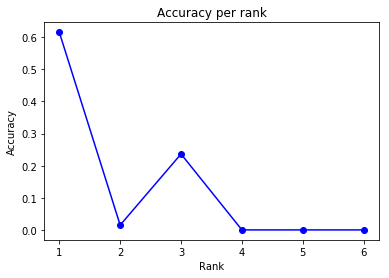

In [87]:
plot_utils.plot_ranks(correct_per_rank, total_per_rank)

#### The reason for the peak in form 3 is NEW YORK, where the state is third most common in the corpus

In [88]:
form='NEW YORK'
print(total_per_form[form])
print(correct_per_form[form])

{'New_York_City': 91, 'New_York': 12, 'New_York_Yankees': 36, 'New_York_Knicks': 4}
{'New_York_City': 0, 'New_York': 12, 'New_York_Yankees': 0, 'New_York_Knicks': 0}


In [89]:
form='Germany'
print(total_per_form[form])
print(correct_per_form[form])

{'Germany': 342, "Germany_men's_national_ice_hockey_team": 1, 'Germany_national_football_team': 6, 'Germany_Davis_Cup_team': 1, 'Germany_Fed_Cup_team': 1}
{'Germany': 315, "Germany_men's_national_ice_hockey_team": 0, 'Germany_national_football_team': 0, 'Germany_Davis_Cup_team': 0, 'Germany_Fed_Cup_team': 0}


#### What is going on with China?

In [90]:
for a in articles:
    for m in a.entity_mentions:
        if m.mention=='China':
            print(m.gold_link, m.sys_link)

China China
China China
China China
China --NME--
China --NME--
China --NME--
China China
China China
China China
China China
China China
China China
China China
China China_Daily
China China_Daily
China China_Daily
China China_Daily
China China
China China
China China
China China
China China
China China
China China
China Northwest_China
China China
China_national_football_team China
China_national_football_team China
China China
China China
China China
China China
China Latvian_Civil_Aviation_Agency
China Latvian_Civil_Aviation_Agency
China Latvian_Civil_Aviation_Agency
China Latvian_Civil_Aviation_Agency
China China
China China
China China
China China
China China
China China
China China
China China
China_national_football_team China
China_national_football_team China
China China
China China
China China
China China
China China_Daily
China China_Daily
China China_Daily
China China
China China
China China
China China
China China_Daily
China China_Daily
China China_Daily
China China
Chin

### 7) PageRank analysis

<span style="background-color:lightgreen">Section 6.6. of the paper</span>

In [91]:
uri_pageranks

{'Nikolai_Lobachevsky': 10.323,
 'February_24': 2.3125,
 '1856': 1.7529,
 'Russia': 2613.6298,
 'Mathematician': 175.8111,
 'List_of_geometers': 5.6926,
 'Hyperbolic_geometry': 24.364,
 'János_Bolyai': 6.0705,
 'Non-Euclidean_geometry': 23.9807,
 'Child': 79.6639,
 'Nizhny_Novgorod': 49.4497,
 '1792': 1.2964,
 'Parent': 32.3217,
 'Polish_language': 325.726,
 'Origen': 51.2307,
 'Clerk': 20.2497,
 'Landscape': 49.5566,
 'Mother': 28.8911,
 'Kazan': 58.9095,
 'Government': 345.7854,
 'Scholarship': 52.911,
 'Kazan_Gymnasium': 0.4737,
 '1802': 1.3029,
 'Graduation': 37.4466,
 '1807': 1.4005,
 'Kazan_(Volga_region)_Federal_University': 8.569,
 'Year': 138.7508,
 '1804': 1.1688,
 'Medicine': 410.742,
 'Course_(education)': 14.7094,
 'Mathematics': 945.4947,
 'Physics': 486.6064,
 'Professor': 212.3474,
 'Johann_Christian_Martin_Bartels': 0.8421,
 'Teacher': 127.3844,
 'Friendship': 26.7207,
 'Germany': 3766.7304,
 'Carl_Friedrich_Gauss': 62.8411,
 'Knowledge': 86.2877,
 "Master's_degree": 2

In [92]:
correct_per_rank_pr=defaultdict(int)
total_per_rank_pr=defaultdict(int)
for form, data in total_per_form.items():
    form_pageranks=[]
    for uri in data.keys():
        form_pageranks.append(tuple((uri_pageranks[uri], uri)))
#        print(correct_by_uri[uri], total_by_uri[uri], uri, uri_pageranks[uri])
#    print(sorted(form_pageranks, reverse=True))
    for rank in range(1,len(form_pageranks)+1):
#        print(rank, form_pageranks[rank-1])
        correct_per_rank_pr[rank]+=correct_by_uri[form_pageranks[rank-1][1]]
        total_per_rank_pr[rank]+=total_by_uri[form_pageranks[rank-1][1]]
#    print(form,data)
#    input('continue')

In [93]:
print(correct_per_rank_pr)
print(total_per_rank_pr)

defaultdict(<class 'int'>, {1: 10513, 2: 5487, 3: 794, 4: 254, 5: 42, 6: 1, 7: 146, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0})
defaultdict(<class 'int'>, {1: 23055, 2: 14881, 3: 2503, 4: 684, 5: 654, 6: 17, 7: 228, 8: 5, 9: 5, 10: 5, 11: 3, 12: 3})


defaultdict(<class 'float'>, {1: 0.45599653003686835, 2: 0.36872522007929576, 3: 0.31721933679584496, 4: 0.3713450292397661, 5: 0.06422018348623854, 6: 0.058823529411764705, 7: 0.6403508771929824, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0})


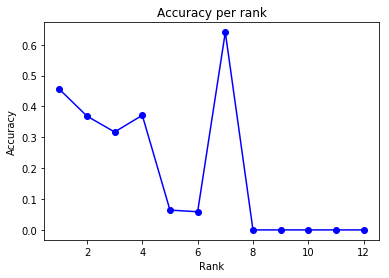

In [94]:
plot_utils.plot_ranks(correct_per_rank_pr, total_per_rank_pr)

### 8) Notes

* connectivity should reflect popularity -> try pageRank
* this is the hardest part of the EL task
* sometimes nils are most frequent
* NILs - maybe set them aside
* very basic baseline - throw away dbpedia, randomly assign from the training data - build this baseline
* always try the most frequent one
* popular, transparent, and the best one - distinguish between open source systems
* look at coreference too (noun phrases and pronouns)
* annotation or not of coreferential expressions (we can also just use them in a solution)? 

**5.3. Aggregate per rank**



#### Summary of the todos:
* Another system or 2 (spotlight) - PIEK: take popular, transparent, and the best one
* More datasets
* NIL entities
* Baseline
* Coreference